In [1]:
import sys, os

## Include previous level directories to the module import path
sys.path.insert(0, os.path.abspath(os.path.join("..")))

import numpy as np
import argparse

from lyaemu import gp_wrap as lk

from cobaya.yaml import yaml_load_file
import arviz as az

# Export the results to GetDist
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt


from matplotlib import pyplot as plt
import matplotlib

from lyaemu.priya_explorer import PRIYAEmulatorExplorer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


def plot_flux_ratio_stacked(
    okf,
    pred,
    zvals,
    param_vals,
    param_name,
    ref_index=5,
    z_idx_list=None,
    ylim=(0.94, 1.06),
    figsize=(6.5, 7.5),
):
    """
    Plot stacked ratio plots of flux power vs reference for selected redshift bins.

    Parameters
    ----------
    okf : list of list of np.ndarray
        k-values for each (param, redshift).
    pred : list of list of np.ndarray
        Emulator predictions (param, redshift).
    zvals : list or np.ndarray
        Redshift values.
    param_vals : list or np.ndarray
        Parameter values used in the sweep.
    param_name : str
        Name of the parameter swept.
    ref_index : int
        Index of the reference prediction.
    z_idx_list : list of int, optional
        Which redshift bins to plot. Default: all.
    ylim : tuple
        y-axis limits for ratio.
    figsize : tuple
        Overall figure size.
    """
    if z_idx_list is None:
        z_idx_list = range(len(zvals))

    # Style
    mpl.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.size": 12,
            "axes.labelsize": 14,
            "legend.fontsize": 12,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
        }
    )

    # Set up color map
    cmap = plt.get_cmap("plasma")
    norm = mpl.colors.Normalize(vmin=min(param_vals), vmax=max(param_vals))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # Set up subplots
    fig, axes = plt.subplots(len(z_idx_list), 1, figsize=figsize, sharex=True)
    if len(z_idx_list) == 1:
        axes = [axes]

    for i_ax, zi in enumerate(z_idx_list):
        ax = axes[i_ax]
        for i_param in range(len(param_vals)):
            k = okf[i_param][zi]
            P = pred[i_param][zi]
            Pref = pred[ref_index][zi]
            ratio = P / Pref
            ax.plot(k, ratio, color=cmap(norm(param_vals[i_param])), lw=2)

        ax.axhline(1.0, color="k", linestyle="--", lw=1)
        ax.set_xscale("log")
        ax.set_xlim(0.0005, 0.02)
        ax.set_ylim(*ylim)
        ax.text(0.02, 0.9, rf"$z = {zvals[zi]:.2f}$", transform=ax.transAxes)

        if i_ax == len(z_idx_list) - 1:
            ax.set_xlabel(r"$k$ [s/km]")
        ax.set_ylabel(r"$P_F(k)/P_{F,\mathrm{ref}}(k)$")

        # gray shaded area for x=0.06 - 0.1
        ax.axvspan(0.065, 0.1, color="gray", alpha=0.2)

        # line at 0.02, label eBOSS DR14
        ax.axvline(0.02, color="k", linestyle="--", lw=1)
        ax.text(0.021, 1.03, "eBOSS", color="k", fontsize=8, rotation=90, va="center")
        # line at 0.045, label XQ-100
        # ax.axvline(0.045, color="k", linestyle="--", lw=1)
        # text vertical
        # ax.text(0.046, 1.03, "XQ100", color="k", fontsize=8, rotation=90, va="center")

    # Add colorbar
    cbar_ax = fig.add_axes([0.91, 0.13, 0.025, 0.74])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(rf"${param_name}$", fontsize=14)

    # ax.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    return fig, axes

## Import P1D data class


In [3]:
from lyaemu.lyman_data import SDSSData, BOSSData, XQ100Data, KSData, XQ1002017Data

sdss = SDSSData()
eboss = BOSSData(datafile="dr14")
eboss_dr9 = BOSSData(datafile="dr9")
kodiaq = KSData()
xq100 = XQ100Data()

xq1002017 = XQ1002017Data()

kodiaq_detail = KSData(conservative=False)

In [4]:
# show matplotlib plots in line
%matplotlib inline

## Generate 1P variation


In [5]:
kf = eboss.get_kf()
# LF emulator
explorer = PRIYAEmulatorExplorer("../Emulator_Files/", kf=kf, hires_subdir=None)
# HF emulator
explorer_hf = PRIYAEmulatorExplorer("../Emulator_Files/", kf=kf, hires_subdir="hires")
# turn off resolution correction
explorer.emulator_wrap.use_res_corr = False
explorer_hf.emulator_wrap.use_res_corr = False

[Info] Parameter limits for the emulator:
ns: 0.800 - 0.995
Ap: 0.000 - 0.000
herei: 3.500 - 4.100
heref: 2.600 - 3.200
alphaq: 1.300 - 2.500
hub: 0.650 - 0.750
omegamh2: 0.140 - 0.146
hireionz: 6.500 - 8.000
bhfeedback: 0.030 - 0.070
[Info] Load the emulator.json parameter file to the emulator.
Beginning to generate emulator at 2025-07-15 18:10:39.441146
Loading flux powers from:  ../Emulator_Files/mf_emulator_flux_vectors_tau1000000.hdf5
Number of redshifts for emulator generation=13 nk= 102
Loading pre-trained GP for z:4.6
Loading pre-trained GP for z:4.4
Loading pre-trained GP for z:4.2
Loading pre-trained GP for z:4.0
Loading pre-trained GP for z:3.8
Loading pre-trained GP for z:3.6
Loading pre-trained GP for z:3.4
Loading pre-trained GP for z:3.2
Loading pre-trained GP for z:3.0
Loading pre-trained GP for z:2.8
Loading pre-trained GP for z:2.6
Loading pre-trained GP for z:2.4
Loading pre-trained GP for z:2.2
Finished generating emulator at 2025-07-15 18:10:43.297279
[Info] Parame

In [6]:
import h5py


# LOO errors
class HDF5DataLoader:
    def __init__(self, base_dir, fig_base):
        self.base_dir = base_dir
        self.fig_base = fig_base

    def load_data(self, file_path):
        with h5py.File(file_path, "r") as file:
            flux_predict = file["flux_predict"][:]
            flux_true = file["flux_true"][:]
            params = file["params"][:]
            std_predict = file["std_predict"][:]

        # Calculate errors
        err = np.abs(flux_predict / flux_true - 1).flatten()
        errSTD = ((flux_predict - flux_true) / std_predict).flatten()

        return flux_predict, flux_true, params, std_predict, err, errSTD

    def load_loo_fps(self):
        loo_fps_path = self.base_dir + "loo_fps.hdf5"
        return self.load_data(loo_fps_path)

    def load_hf_fps(self):
        hf_fps_path = self.base_dir + "hires/loo_fps.hdf5"
        return self.load_data(hf_fps_path)


# Usage
base_dir = "../Emulator_Files/"
figbase = "figures/"

data_loader = HDF5DataLoader(base_dir, figbase)
loo_fps_data = data_loader.load_loo_fps()
hf_fps_data = data_loader.load_hf_fps()

# If you need to access the errors directly, for example:
fpp, fpt, pp, std, err, errSTD = loo_fps_data
MFfpp, MFfpt, MFpp, MFstd, MFerr, MFerrSTD = hf_fps_data

In [7]:
# LF only
pred_div_true = fpp / fpt

flower, fmedian, fupper = np.quantile(pred_div_true, q=(0.16, 0.5, 0.84), axis=0)
loo_error = (fupper - flower) / 2  # estimated loo error

# Multi-fidelity
pred_div_true = MFfpp / MFfpt

flower, fmedian, fupper = np.quantile(pred_div_true, q=(0.16, 0.5, 0.84), axis=0)
loo_error_hf = (fupper - flower) / 2  # estimated loo error

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_71017/2827448796.py:104: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_71017/185187870.py:79: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


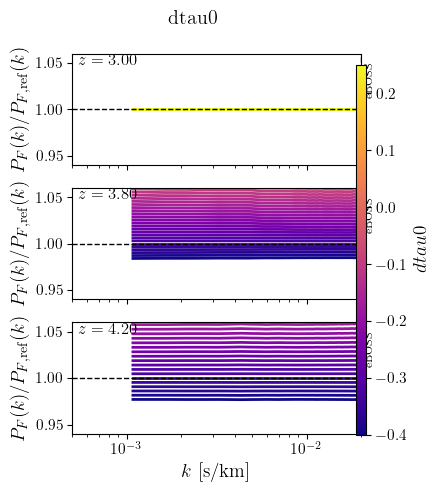

 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_71017/2827448796.py:104: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_71017/185187870.py:97: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


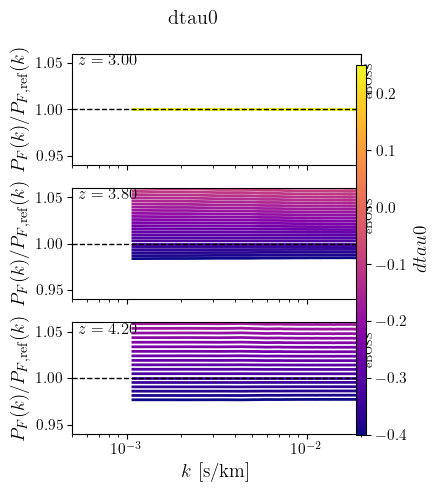

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


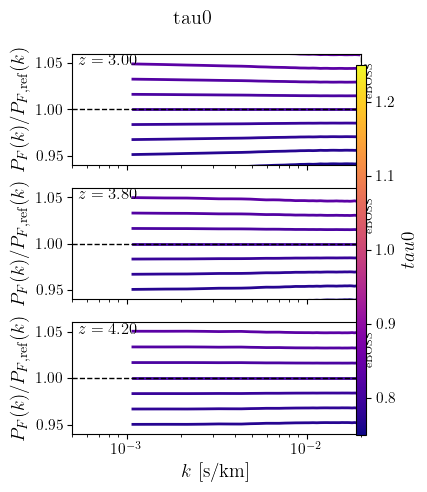

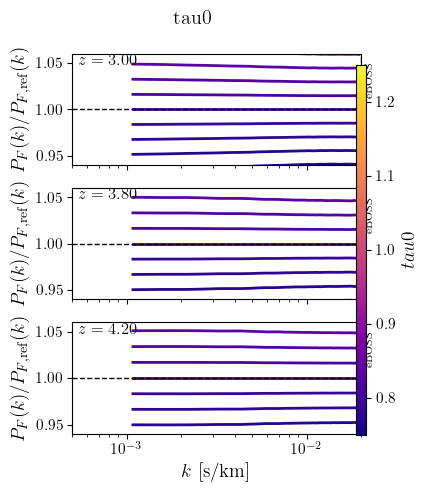

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


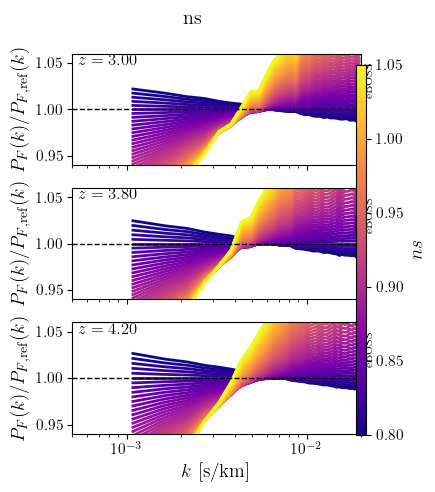

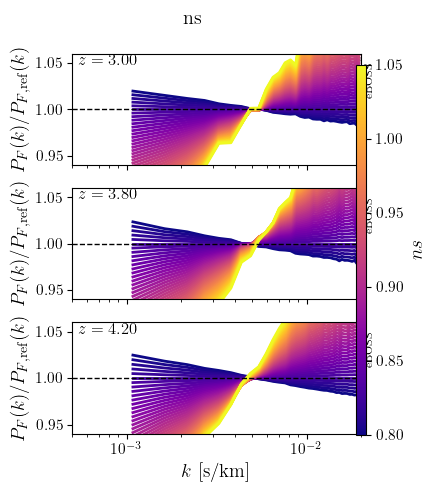

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


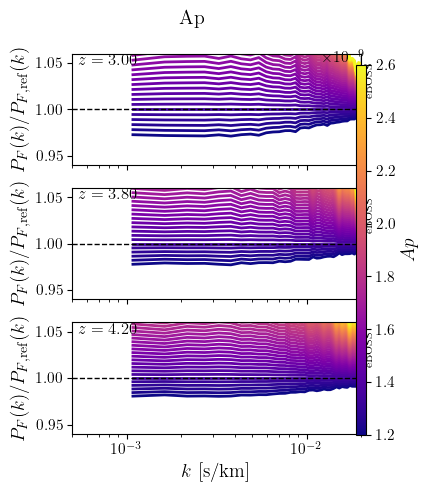

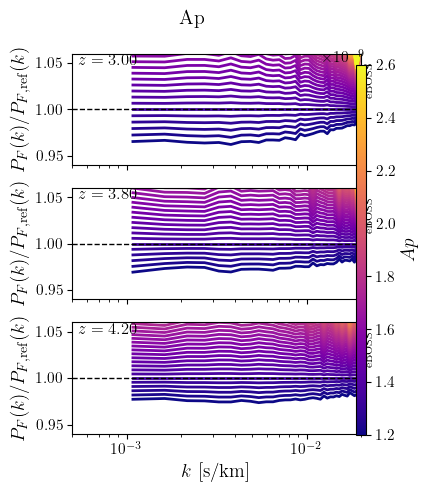

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


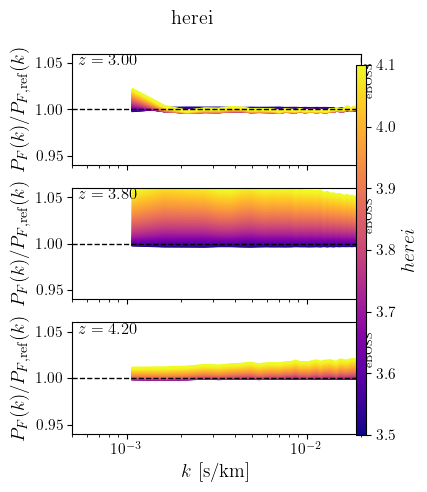

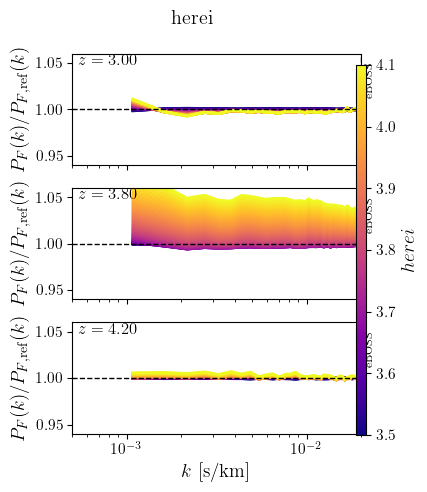

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


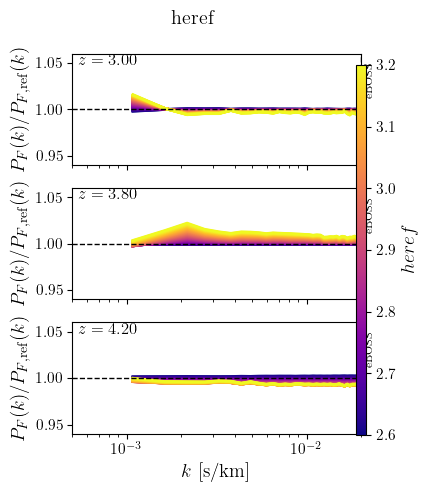

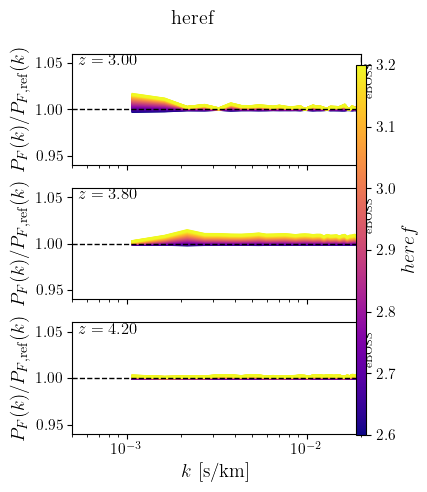

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


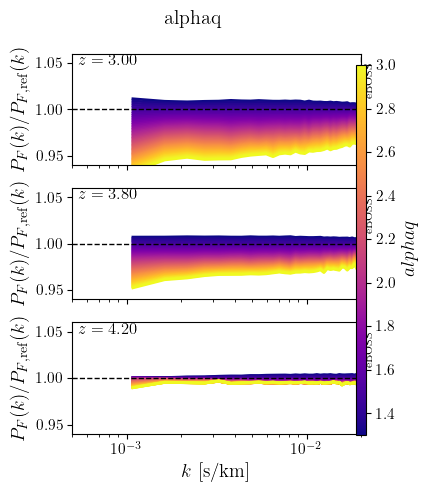

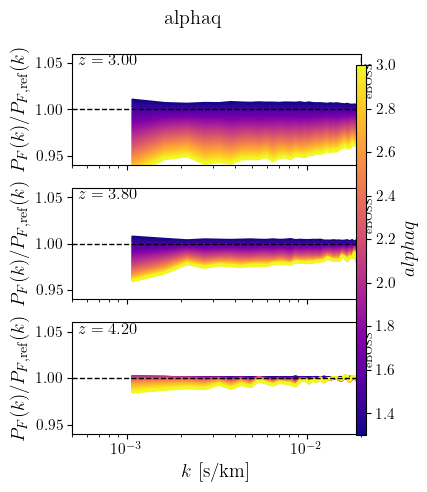

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


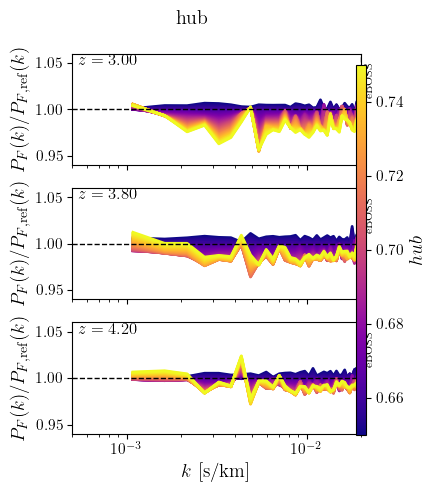

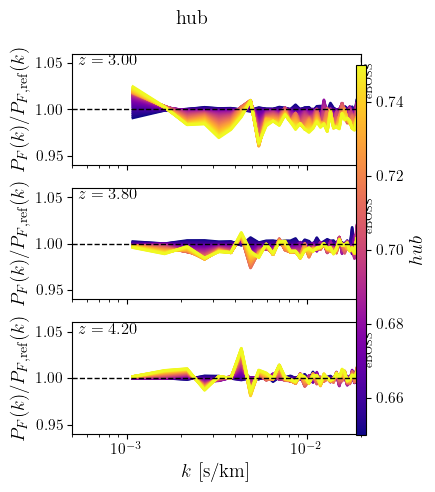

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


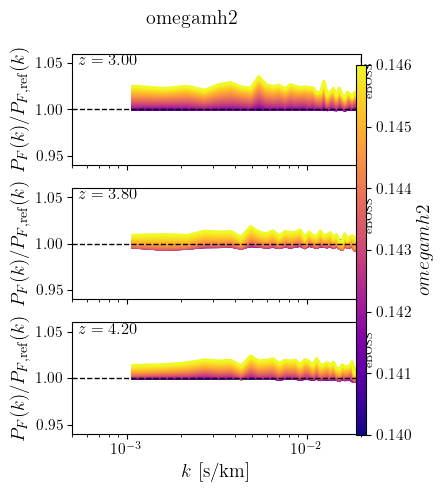

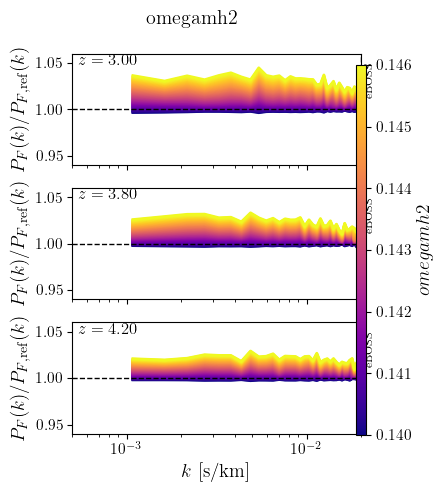

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


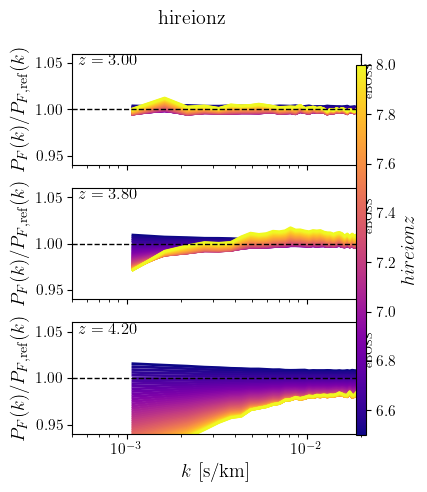

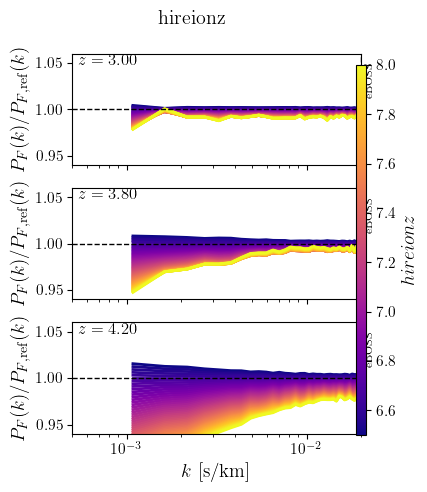

Using best-fit parameters for MF emulator (with slope).
Using best-fit parameters for MF emulator (with slope).


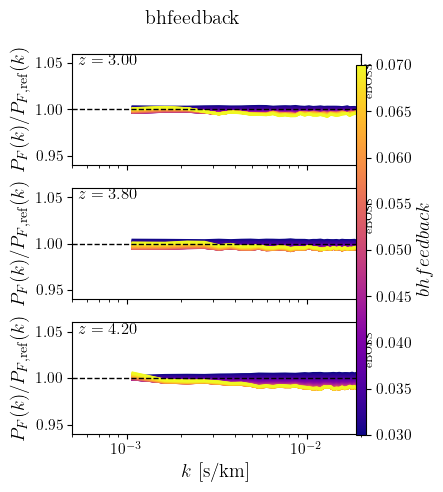

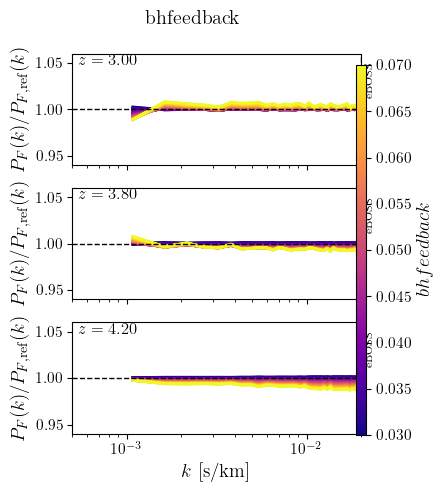

In [8]:
import h5py

param_names = [
    "dtau0",
    "tau0",
    "ns",
    "Ap",
    "herei",
    "heref",
    "alphaq",
    "hub",
    "omegamh2",
    "hireionz",
    "bhfeedback",
]

# param_name = "dtau0"
data_corr = False
npoints = 50

# check if the directory exists, if not create it
if not os.path.exists("../1pvar/figures"):
    os.makedirs("../1pvar/figures")

# Sample 1P predictions for each parameter
for param_name in param_names:
    explorer._set_best_fit_params()
    explorer_hf._set_best_fit_params()

    okf, pred, std, params_1p = explorer.sample_1P_predictions(
        param_name, npoints=npoints, data_corr=data_corr, return_prior=True
    )
    okf_hf, pred_hf, std_hf, params_1p_hf = explorer_hf.sample_1P_predictions(
        param_name, npoints=npoints, data_corr=data_corr, return_prior=True
    )

    with h5py.File(
        f"../1pvar/lf_{param_name}_npoints{npoints}_datacorr{data_corr}.hdf5",
        "w",
    ) as file:
        file.create_dataset("params", data=np.array(params_1p))
        file.create_dataset("kfkms", data=np.array(okf))
        file.create_dataset("flux_vectors", data=np.array(pred))
        file.create_dataset("loo_error", data=np.array(loo_error))
        file.create_dataset("zout", data=np.array(explorer.zz))

    # HF
    with h5py.File(
        f"../1pvar/hf_{param_name}_npoints{npoints}_datacorr{data_corr}.hdf5",
        "w",
    ) as file:
        file.create_dataset("params", data=np.array(params_1p_hf))
        file.create_dataset("kfkms", data=np.array(okf_hf))
        file.create_dataset("flux_vectors", data=np.array(pred_hf))
        file.create_dataset("loo_error", data=np.array(loo_error_hf))
        file.create_dataset("zout", data=np.array(explorer_hf.zz))

    # Some plotting for sure
    param_vals = np.linspace(
        explorer.emulator_wrap._param_limits[explorer.param_names[param_name]][0],
        explorer.emulator_wrap._param_limits[explorer.param_names[param_name]][1],
        npoints,
    )
    zout = explorer.emulator_wrap.zout
    z_idx_list = [np.argmin(np.abs(zout - z)) for z in [3.0, 3.8, 4.2]]

    fig, axes = plot_flux_ratio_stacked(
        okf,
        pred,
        zout,
        param_vals=param_vals,
        param_name=param_name,
        ref_index=5,
        z_idx_list=z_idx_list,
        figsize=(4, 5),
        # ylim=(0.94, 1.06),
    )
    fig.suptitle(param_name)
    plt.tight_layout()
    fig.savefig(
        f"../1pvar/figures/lf_1pvar_{param_name}_npoints{npoints}_datacorr{data_corr}.png",
        bbox_inches="tight",
    )
    plt.show()
    fig, axes = plot_flux_ratio_stacked(
        okf_hf,
        pred_hf,
        zout,
        param_vals=param_vals,
        param_name=param_name,
        ref_index=5,
        z_idx_list=z_idx_list,
        figsize=(4, 5),
        # ylim=(0.94, 1.06),
    )
    fig.suptitle(param_name)
    plt.tight_layout()
    fig.savefig(
        f"../1pvar/figures/lf_1pvar_{param_name}_npoints{npoints}_datacorr{data_corr}.png",
        bbox_inches="tight",
    )
    plt.show()